In [1]:
import pandas as pd
from PIL import Image
import numpy as np

In [2]:
train_csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
test_csv_path = '/kaggle/input/rsna-breast-cancer-detection/test.csv'

dataset_images_path = '/kaggle/input/rsna-breast-cancer-256-pngs/'

In [3]:
df = pd.read_csv(train_csv_path)
df['patient_id_str'] = df['patient_id'].astype(str)
df['image_id_str'] = df['image_id'].astype(str)

cancer_df = df.loc[df['cancer'] == 1]

no_cancer_df = df.loc[df['cancer'] == 0]
no_cancer_df = no_cancer_df.iloc[:len(cancer_df)]

df = pd.concat([cancer_df, no_cancer_df], ignore_index = True)
df.reset_index()

train_df = df[['patient_id', 'image_id', 'cancer', 'laterality', 'patient_id_str', 'image_id_str']]
train_df['image_name'] = ''

for i in range(len(train_df)):
    train_df['image_name'][i] = train_df['patient_id_str'][i] + '_'+ train_df['image_id_str'][i] + '.png'

train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,patient_id,image_id,cancer,laterality,patient_id_str,image_id_str,image_name
0,10130,388811999,1,L,10130,388811999,10130_388811999.png
1,10130,613462606,1,L,10130,613462606,10130_613462606.png
2,10130,1360338805,1,L,10130,1360338805,10130_1360338805.png
3,10130,1672636630,1,L,10130,1672636630,10130_1672636630.png
4,10226,461614796,1,L,10226,461614796,10226_461614796.png


In [4]:
train_df['image_arr'] = ''

for i in range(len(train_df)):
    train_df['image_arr'][i] = np.array(Image.open(dataset_images_path + train_df['image_name'][i]))
    
train_df_L = train_df[(train_df['laterality'] == 'L')]
train_df_R = train_df[(train_df['laterality'] == 'R')]

print(train_df_L.head())
print(train_df_R.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


   patient_id    image_id  cancer laterality patient_id_str image_id_str  \
0       10130   388811999       1          L          10130    388811999   
1       10130   613462606       1          L          10130    613462606   
2       10130  1360338805       1          L          10130   1360338805   
3       10130  1672636630       1          L          10130   1672636630   
4       10226   461614796       1          L          10226    461614796   

             image_name                                          image_arr  
0   10130_388811999.png  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1   10130_613462606.png  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  10130_1360338805.png  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  10130_1672636630.png  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4   10226_461614796.png  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
    patient_id    image_id  cancer laterality patient_id_str image_id_str  \
19  

In [5]:
from tensorflow.keras.utils import to_categorical

XL = np.asarray(train_df_L['image_arr'].tolist())
XL = XL/255.0
YL = to_categorical(train_df_L['cancer'], num_classes=2)

XR = np.asarray(train_df_R['image_arr'].tolist())
XR = XR/255.0
YR = to_categorical(train_df_R['cancer'], num_classes=2)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from sklearn.model_selection import train_test_split

x_train_L, x_test_L, y_train_L, y_test_L = train_test_split(XL, YL, test_size=0.20, random_state=42)
x_train_R, x_test_R, y_train_R, y_test_R = train_test_split(XR, YR, test_size=0.20, random_state=42)

model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(256, 256, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

#--------------------------------------------------------------------------------------

model1 = Sequential()

model1.add(Conv2D(256, (3, 3), activation="relu", input_shape=(256, 256, 1)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(128, (3, 3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))

model1.add(Conv2D(64, (3, 3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))
model1.add(Flatten())

model1.add(Dense(32))
model1.add(Dense(2, activation='softmax'))
model1.summary()

model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        7

In [7]:
import tensorflow as tf

batch_size = 16

x_train_L = x_train_L.reshape(-1, 256, 256, 1)
x_test_L = x_test_L.reshape(-1, 256, 256, 1)

x_train_R = x_train_R.reshape(-1, 256, 256, 1)
x_test_R = x_test_R.reshape(-1, 256, 256, 1)

In [8]:
history_L = model.fit(x_train_L, y_train_L, batch_size=batch_size, epochs=50, validation_data=(x_test_L, y_test_L), verbose=2)

Epoch 1/50
58/58 - 24s - loss: 0.7219 - acc: 0.4968 - val_loss: 0.6879 - val_acc: 0.5776
Epoch 2/50
58/58 - 10s - loss: 0.6813 - acc: 0.5790 - val_loss: 0.6740 - val_acc: 0.5948
Epoch 3/50
58/58 - 10s - loss: 0.6637 - acc: 0.6126 - val_loss: 0.6683 - val_acc: 0.5991
Epoch 4/50
58/58 - 10s - loss: 0.6314 - acc: 0.6472 - val_loss: 0.6769 - val_acc: 0.5733
Epoch 5/50
58/58 - 10s - loss: 0.5944 - acc: 0.6710 - val_loss: 0.7428 - val_acc: 0.5043
Epoch 6/50
58/58 - 10s - loss: 0.5430 - acc: 0.7100 - val_loss: 0.7326 - val_acc: 0.5302
Epoch 7/50
58/58 - 10s - loss: 0.4880 - acc: 0.7219 - val_loss: 0.7586 - val_acc: 0.5129
Epoch 8/50
58/58 - 10s - loss: 0.4314 - acc: 0.7727 - val_loss: 0.9819 - val_acc: 0.5000
Epoch 9/50
58/58 - 10s - loss: 0.3798 - acc: 0.8041 - val_loss: 1.0280 - val_acc: 0.5043
Epoch 10/50
58/58 - 10s - loss: 0.3416 - acc: 0.8268 - val_loss: 1.0506 - val_acc: 0.5086
Epoch 11/50
58/58 - 10s - loss: 0.2974 - acc: 0.8485 - val_loss: 1.3116 - val_acc: 0.4957
Epoch 12/50
58/58 -

In [9]:
score_L = model.evaluate(x_test_L, y_test_L)
print('Left Test accuracy:', score_L[1])

8/8 [==============================] - 2s 105ms/step - loss: 4.3210 - acc: 0.5000
Left Test accuracy: 0.5


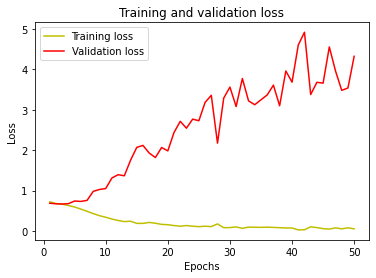

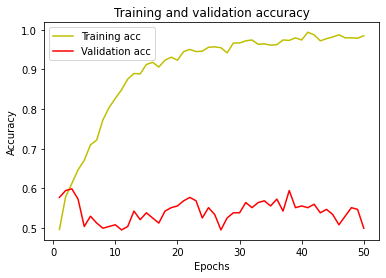

In [10]:
import matplotlib.pyplot as plt

loss = history_L.history['loss']
val_loss = history_L.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history_L.history['acc']
val_acc = history_L.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
history_R = model1.fit(x_train_R, y_train_R, batch_size=batch_size, epochs=50, validation_data=(x_test_R, y_test_R), verbose=2)

Epoch 1/50
58/58 - 11s - loss: 0.7156 - acc: 0.4741 - val_loss: 0.6924 - val_acc: 0.4914
Epoch 2/50
58/58 - 10s - loss: 0.6916 - acc: 0.5647 - val_loss: 0.6880 - val_acc: 0.5733
Epoch 3/50
58/58 - 10s - loss: 0.6742 - acc: 0.6024 - val_loss: 0.6848 - val_acc: 0.5259
Epoch 4/50
58/58 - 10s - loss: 0.6442 - acc: 0.6336 - val_loss: 0.6983 - val_acc: 0.5733
Epoch 5/50
58/58 - 10s - loss: 0.6176 - acc: 0.6541 - val_loss: 0.7176 - val_acc: 0.5647
Epoch 6/50
58/58 - 10s - loss: 0.5632 - acc: 0.6864 - val_loss: 0.8395 - val_acc: 0.5560
Epoch 7/50
58/58 - 10s - loss: 0.5126 - acc: 0.7306 - val_loss: 0.9193 - val_acc: 0.5776
Epoch 8/50
58/58 - 10s - loss: 0.4543 - acc: 0.7737 - val_loss: 1.0517 - val_acc: 0.5345
Epoch 9/50
58/58 - 10s - loss: 0.3996 - acc: 0.7888 - val_loss: 1.0871 - val_acc: 0.5991
Epoch 10/50
58/58 - 10s - loss: 0.3921 - acc: 0.8103 - val_loss: 1.0238 - val_acc: 0.5474
Epoch 11/50
58/58 - 10s - loss: 0.3145 - acc: 0.8362 - val_loss: 1.2594 - val_acc: 0.5905
Epoch 12/50
58/58 -

In [12]:
score_R = model1.evaluate(x_test_R, y_test_R)
print('Right Test accuracy:', score_R[1])

8/8 [==============================] - 1s 105ms/step - loss: 4.3347 - acc: 0.5948
Right Test accuracy: 0.5948275923728943


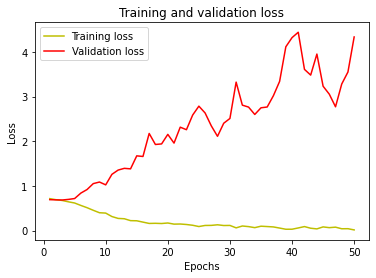

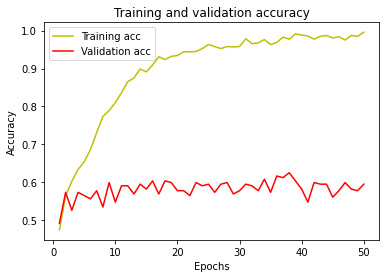

In [13]:
import matplotlib.pyplot as plt

loss = history_R.history['loss']
val_loss = history_R.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history_R.history['acc']
val_acc = history_R.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Submission

In [14]:
import pandas as pd
test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [15]:
test_df['patient_id_str'] = test_df['patient_id'].astype(str)
test_df['image_id_str'] = test_df['image_id'].astype(str)


test_df = test_df[['patient_id', 'image_id', 'laterality', 'patient_id_str', 'image_id_str']]
test_df['image_name'] = ''

for i in range(len(test_df)):
    test_df['image_name'][i] = test_df['patient_id_str'][i] + '_'+ test_df['image_id_str'][i] + '.png'

test_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


,patient_id,image_id,laterality,patient_id_str,image_id_str,image_name
0,10008,736471439,L,10008,736471439,10008_736471439.png
1,10008,1591370361,L,10008,1591370361,10008_1591370361.png
2,10008,68070693,R,10008,68070693,10008_68070693.png
3,10008,361203119,R,10008,361203119,10008_361203119.png


In [16]:
from PIL import Image

test_df['image_arr'] = ''

for i in range(len(test_df)):
    test_df['image_arr'][i] = np.array(Image.open('/kaggle/input/rsna-breast-cancer-test-png-images/my_test_data/' + test_df['image_name'][i]))
    
test_df_L = test_df[(test_df['laterality'] == 'L')]
test_df_R = test_df[(test_df['laterality'] == 'R')]

print(test_df_L.head())
print(test_df_R.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


   patient_id    image_id laterality patient_id_str image_id_str  \
0       10008   736471439          L          10008    736471439   
1       10008  1591370361          L          10008   1591370361   

             image_name                                          image_arr  
0   10008_736471439.png  [[83, 106, 120, 113, 125, 130, 126, 146, 145, ...  
1  10008_1591370361.png  [[62, 64, 56, 60, 54, 54, 50, 50, 51, 49, 47, ...  
   patient_id   image_id laterality patient_id_str image_id_str  \
2       10008   68070693          R          10008     68070693   
3       10008  361203119          R          10008    361203119   

            image_name                                          image_arr  
2   10008_68070693.png  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  10008_361203119.png  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  


In [17]:
from tensorflow.keras.utils import to_categorical

XL = np.asarray(test_df_L['image_arr'].tolist())
XL = XL/255.0

XR = np.asarray(test_df_R['image_arr'].tolist())
XR = XR/255.0

xr = []
xr.append(XR[0][:, :, np.newaxis])
xr.append(XR[1][:, :, np.newaxis])
xr = np.array(xr)

xl = []
xl.append(XL[0][:, :, np.newaxis])
xl.append(XL[1][:, :, np.newaxis])
xl = np.array(xl)


In [18]:
pred_df = pd.DataFrame(columns=['prediction_id','cancer'])
pred_df.loc[0] = ['10008-L', (model.predict(xl)[0][0] + model.predict(xl)[1][0])/2]
pred_df.loc[1] = ['10008-R', (model1.predict(xr)[0][0] + model1.predict(xr)[1][0])/2]
pred_df

,prediction_id,cancer
0,10008-L,0.509518
1,10008-R,0.682573


In [19]:
pred_df.to_csv('submission.csv')